In [10]:
import tarfile
tar = tarfile.open('data.tar.gz')
tar.extractall()

In [ ]:
rm data.tar.gz

In [9]:
ls

data.tar.gz  sample_data/


In [11]:
pip install split-folders

In [12]:
import splitfolders
splitfolders.ratio("/content/Resize", output="splitted_data", seed=43, ratio=(.8,.1,.1))

Copying files: 5299 files [00:00, 6144.12 files/s]


Number of train dataset:  4238
Number of test dataset:  532
Number of validation dataset:  529


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


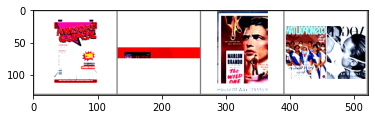

Epoch: 1 	Training Loss: 1.022063
Epoch: 2 	Training Loss: 0.945372
Epoch: 3 	Training Loss: 0.911433
Epoch: 4 	Training Loss: 0.883801
Epoch: 5 	Training Loss: 0.871140
Epoch: 6 	Training Loss: 0.851629
Epoch: 7 	Training Loss: 0.831317
Epoch: 8 	Training Loss: 0.813615
Epoch: 9 	Training Loss: 0.801519
Epoch: 10 	Training Loss: 0.787578
Epoch: 11 	Training Loss: 0.776251
Epoch: 12 	Training Loss: 0.760411
Epoch: 13 	Training Loss: 0.744234
Epoch: 14 	Training Loss: 0.738472
Epoch: 15 	Training Loss: 0.726876
Epoch: 16 	Training Loss: 0.711800
Epoch: 17 	Training Loss: 0.705159
Epoch: 18 	Training Loss: 0.691629
Epoch: 19 	Training Loss: 0.676302
Epoch: 20 	Training Loss: 0.655942
Epoch: 21 	Training Loss: 0.652375
Epoch: 22 	Training Loss: 0.641653
Epoch: 23 	Training Loss: 0.631900
Epoch: 24 	Training Loss: 0.613489
Epoch: 25 	Training Loss: 0.612184
Epoch: 26 	Training Loss: 0.608034
Epoch: 27 	Training Loss: 0.589493
Epoch: 28 	Training Loss: 0.581592
Epoch: 29 	Training Loss: 0.5

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters 
num_epochs = 75
batch_size = 4
learning_rate = 0.001

# dataset has PILImage images of range [0, 1]. 
# We transform them to Tensors of normalized range [-1, 1]
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.RandomHorizontalFlip(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])])
transform2 = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])])

# Define datasets as train, test and validation.
train_dataset = torchvision.datasets.ImageFolder(root='/content/splitted_data/train', 
                                                 transform=transform)
print("Number of train dataset: ",len(train_dataset))
test_dataset = torchvision.datasets.ImageFolder(root='/content/splitted_data/test',
                                                transform=transform)
print("Number of test dataset: ",len(test_dataset))
valid_dataset = torchvision.datasets.ImageFolder(root='/content/splitted_data/val',
                                                transform=transform2)
print("Number of validation dataset: ",len(valid_dataset))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size,
                                         shuffle=False)

classes = ("book_cover", "magazine_cover", "movie_poster")

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

class ConvNet(nn.Module):
    def __init__(self):
      super(ConvNet, self).__init__()

      # Constraints for layer 1
      self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride = 1, padding=1)
      self.pool1 = nn.MaxPool2d(kernel_size=2) #default stride is equivalent to the kernel_size
      self.batch1= nn.BatchNorm2d(16)
      self.relu1 = nn.ReLU()
      self.dout1 = nn.Dropout(0.2) 
      # Constraints for layer 2
      self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride = 1, padding=1)
      self.pool2 = nn.MaxPool2d(kernel_size=2)   
      self.batch2= nn.BatchNorm2d(32)
      self.relu2 = nn.ReLU()
      self.dout2 = nn.Dropout(0.2)   
      # Defining the Linear layer
      self.fc1 = nn.Linear(32*32*32, 12)
      self.fc2 = nn.Linear(12, 6)
      self.fc3 = nn.Linear(6, 3)

    def forward(self, x):
      # Conv 1
      out = self.conv1(x)
      out = self.batch1(out) 
      out = self.relu1(out)
      out = self.pool1(out)
      out = self.dout1(out)
      # Conv 2
      out = self.conv2(out)
      out = self.batch2(out) 
      out = self.relu2(out)
      out = self.pool2(out)
      out = self.dout2(out)
      out = out.view(out.size(0), -1)
      # Linear Layer
      out = self.fc1(out)         
      out = self.fc2(out)  
      out = self.fc3(out)                
      return out


model = ConvNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    train_loss = 0.
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        loss.backward()
        optimizer.step()

        train_loss += loss.item()*images.size(0)
        
    # print training statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.dataset)

    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch+1, 
        train_loss
        ))
    
print('Finished Training')
PATH = './cnn.pth'
torch.save(model.state_dict(), PATH)
print("-"*50)


# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(3))
class_total = list(0. for i in range(3))

model.eval() # prep model for *evaluation*

for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(3):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))